# Changepoints

Changepoints are moments of sudden, simultaneous change in the trajectories of multiple keypoints. This notebook shows how to compute a change score, find changepoints and visualize the result. 

## Load data

This notebook assumes that the initial steps of [project setup and configuration](https://keypoint-moseq.readthedocs.io/en/latest/tutorial.html#project-setup) have been completed.

In [4]:
import keypoint_moseq as kpms
import sys
sys.path.insert(0, 'C:/Users/MyPC/Desktop/git/AVATAR_motionMap')
import FileManager.csvload as acl

project_dir = r'C:\Users\MyPC\Desktop\git\kp_moseq\keypoint-moseq\project\SDSBD\dataset5\trainset1'
config = lambda: kpms.load_config(project_dir)

# load data from DeepLabCut
# dlc_results_directory = '../../testing/dlc_project/videos/'
# coordinates, confidences = kpms.load_deeplabcut_results(dlc_results_directory)

# load data from SLEAP
# sleap_results_directory = '...'
# coordinates, confidences = kpms.load_sleap_results(sleap_results_directory)

# load data from AVATAR .csv file
#kpms.generate_grid_movies(results, project_dir, model_name, coordinates=coordinates, **config())

# for 3D data, include the flag `keypoints_only=True`
keypoint_data_path = acl.get_csv_paths(r'C:\Users\MyPC\Desktop\실험실\2.실험데이터\AVATAR-SDSBD\dataset5\trainset1.txt')
new_data = acl.get_csv_paths(r'C:\Users\MyPC\Desktop\실험실\2.실험데이터\AVATAR-SDSBD\dataset5\testset1.txt')

dataset = [keypoint_data_path, new_data] #acl.get_csv_paths(r'C:\Users\MyPC\Desktop\실험실\2.실험데이터\AVATAR-SDSBD\dataset3\kp-moseq\totaldata.txt')
coordinates, bodyparts = kpms.load_keypoints_AVATAR(dataset, path_in_name=False, remove_extension=True)

Loading keypoints: 100%|██████████| 77/77 [00:04<00:00, 18.51it/s]


## Find changepoints


Changepoints are local peaks in a change score that is computed by:

1. Differentiating (egocentrically aligned) keypoint coordinates
2. Z-scoring the absolute values of each derivative
3. Counting the number keypoint-coordinate pairs where the 
   Z-score crosses a threshold (in each frame).
4. Computing a p-value for the number of threshold-crossings
   using a temporally shuffled null distribution
5. Smoothing the resulting significance score across time

Steps (3-5) are performed for a range of threshold values, and 
the final outputs are based on the threshold that yields the 
highest changepoint frequency.

In [12]:

anterior_bodyparts=['nose']
posterior_bodyparts=['anus']
bodyparts = ['nose','neck','anus','chest','rfoot','lfoot','rhand','lhand','tip']
use_bodyparts=['nose','neck','anus','chest','rfoot','lfoot','rhand','lhand']

(changepoints, changescores, coordinates_ego, derivatives, threshold
) = kpms.changepoint_analysis(coordinates,anterior_bodyparts=anterior_bodyparts,posterior_bodyparts=posterior_bodyparts,use_bodyparts=use_bodyparts,bodyparts=bodyparts)


Aligning keypoints
Differentiating and z-scoring


Testing thresholds: 100%|███████████████| 20/20 [00:17<00:00,  1.17it/s]


## Plot inter-changepoint intervals distribution

One strategy for picking the `kappa` hyperparameter during modeling is to match the disbution of syllable durations to the distribution of inter-changepoint intervals. The histogram below shows the distribution of inter-changepoint-intervals.


Median inter-changepoint interval = 0.55 seconds (11.0 frames)


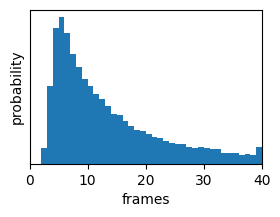

In [13]:
import keypoint_moseq as kpms
import matplotlib.pyplot as plt
import numpy as np

fps = 20 # framerate, adjust as necessary
upper_bound = 2 # upper range of histogram

intervals = np.hstack([np.diff(v) for v in changepoints.values()])
med = np.median(intervals)
print(f'Median inter-changepoint interval = {round(med/fps,2)} seconds ({med} frames)')
plt.hist(intervals, bins=40, range=(0,upper_bound*fps))
plt.xlim([0,upper_bound*fps])
plt.xlabel('frames')
plt.ylabel('probability')
plt.yticks([])
plt.gcf().set_size_inches((3,2))

## Visualize changepoints

The code below picks a random session and timepoint, and then plots the following:

1. Keypoints in egocentric coordinates (anterior-posterior axis)
2. Keypoints in egocentric coordinates (left-right axis)
3. Z-scored absolute values of the derivatives of each keypoint
4. Same as (3), but binarized using `threshold`
5. Changescore, with changepoints marked by dots

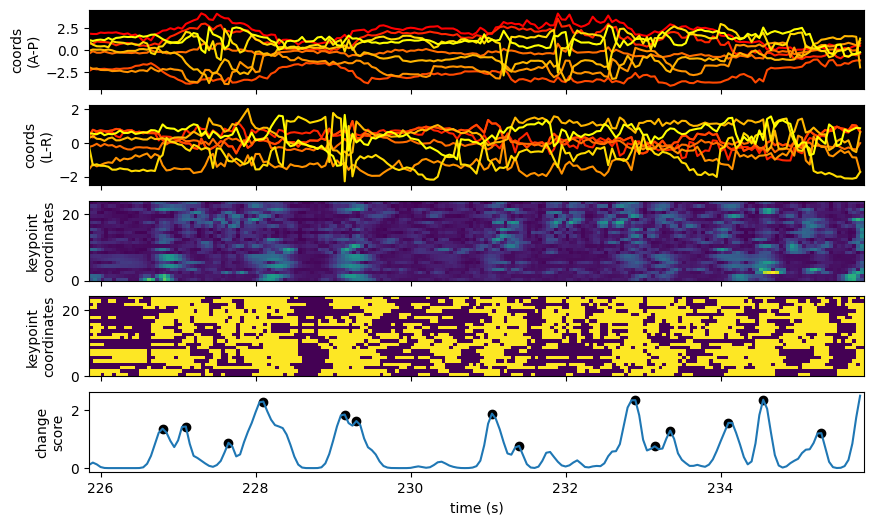

In [14]:
import matplotlib.pyplot as plt
import numpy as np

fps = 20 # framerate, adjust as necessary
window_size = fps*10 # number of frames to plot
keypoint_colormap = config()['keypoint_colormap']

fig,axs = plt.subplots(5,1,sharex=True)

# choose a random session and timepoint
np.random.seed(30)
session = np.random.choice(list(coordinates.keys()))
timepoint = np.random.randint(0,len(coordinates[session])-window_size)
ixs = np.arange(timepoint,timepoint+window_size, dtype=int)

# plot coordinates
cmap = plt.colormaps[keypoint_colormap]
coords = coordinates_ego[session][ixs]
for i in range(coords.shape[1]):
    axs[0].plot(ixs/fps, coords[:,i,0], c=cmap(i/(coords.shape[1]-1)))
    axs[1].plot(ixs/fps, coords[:,i,1], c=cmap(i/(coords.shape[1]-1)))
    
axs[0].set_facecolor('k')
axs[0].set_ylabel('coords\n(A-P)')
axs[1].set_facecolor('k')
axs[1].set_ylabel('coords\n(L-R)')

# plot z-scored absolute values of the derivatives of each keypoint
ds = derivatives[session][ixs]
ds = np.moveaxis(ds,2,1).reshape(window_size,-1)
extent = [timepoint/fps, (timepoint+window_size)/fps, 0, ds.shape[1]]
axs[2].imshow(ds.T, aspect='auto', interpolation='nearest', extent=extent)
axs[2].set_ylabel('keypoint\ncoordinates')

# plot binarized z-scores
axs[3].imshow(ds.T > threshold, aspect='auto', interpolation='nearest', extent=extent)
axs[3].set_ylabel('keypoint\ncoordinates')

# plot changescore and changepoints
cps = np.intersect1d(changepoints[session], ixs)
axs[4].plot(ixs/fps, changescores[session][ixs])
axs[4].scatter(cps/fps, changescores[session][cps], c='k')
axs[4].set_ylabel('change\nscore')
axs[4].set_xlabel('time (s)')

fig.set_size_inches((10,6))